In this notebook we study behaviors of different models once locdowns are imposed. We consider the following models: SIR, SEIR, SIkR and SEkIkR.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=16  ## number of age classes
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
Ni = (my_data[:, 1]+ my_data[:, 2])[0:M]

In [4]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.India()

# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)


Tf=40;  Nf=600 
times= [20, Tf] # temporal boundaries between different contact-behaviour
aW, aS, aO = 0.0, 0.0, 0.0

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # between first and second time
                ]         

# generate corresponding contact matrix function
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

## SIR

In [5]:
beta  = 0.01646692      # probability of infection on contact 
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=14;  Is_0[2:6]=13
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# start simulation
dataSIR =model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
IsSIR = model.Is(dataSIR)

## SEIR

In [6]:
beta  = 0.0274           # probability of infection on contact 
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gE    = 1/2.72          # recovery rate of exposeds
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=14;  Is_0[2:6]=13
Ia_0 = np.zeros((M))
E_0 = np.zeros((M)); 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
model = pyross.deterministic.SEIR(parameters, M, Ni)


# start simulation
dataSEIR =model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
IsSEIR = model.Is(dataSEIR)

## SIkR

In [7]:
beta = 0.01324           # probability of infection on contact 
gI   = 1./7            # recovery rate of  infectives 
gE   = 1/2.72          # recovery rate of exposeds
kI   = 32;              # # of stages of I class


I0 = np.zeros((kI,M));
for i in range(kI):
    I0[i, 6:13]=14;  I0[i, 2:6]=13
S0 = np.zeros(M)  
for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i])
I0 = np.reshape(I0, kI*M)/kI


parameters = {'beta':beta, 'gI':gI, 'kI':kI}
model = pyross.deterministic.SIkR(parameters, M, Ni)
dataSIkR=model.simulate(S0, I0, contactMatrix, Tf, Nf)
ISIkR = model.I(dataSIkR)

## SEkIkR

In [8]:
beta = 0.0188           # probability of infection on contact 
gI   = 1./7              # recovery rate of  infectives 
gE   = 1/2.72            # recovery rate of exposeds
kI   = 32;               # # of stages of I class
kE   = 2;                # # of stages of E class 


S0 = np.zeros(M)  
I0 = np.zeros((kI,M));
E0 = np.zeros((kE,M));
for i in range(kI):
    I0[i, 6:13]=14;  I0[i, 2:6]=13
for i in range(kE):
    E0[i, 0:16]=14
for i in range(M) :
    S0[i] = Ni[i] - np.sum(I0[:,i]) - np.sum(E0[:,i])
I0 = np.reshape(I0, kI*M)/kI;
E0 = np.reshape(E0, kE*M)/kE;


parameters = {'beta':beta, 'gE':gE, 'gI':gI, 'kI':kI, 'kE' : kE}
model = pyross.deterministic.SEkIkR(parameters, M, Ni)
data=model.simulate(S0, E0, I0, contactMatrix, Tf, Nf)
ISEkIkR = model.I(data)

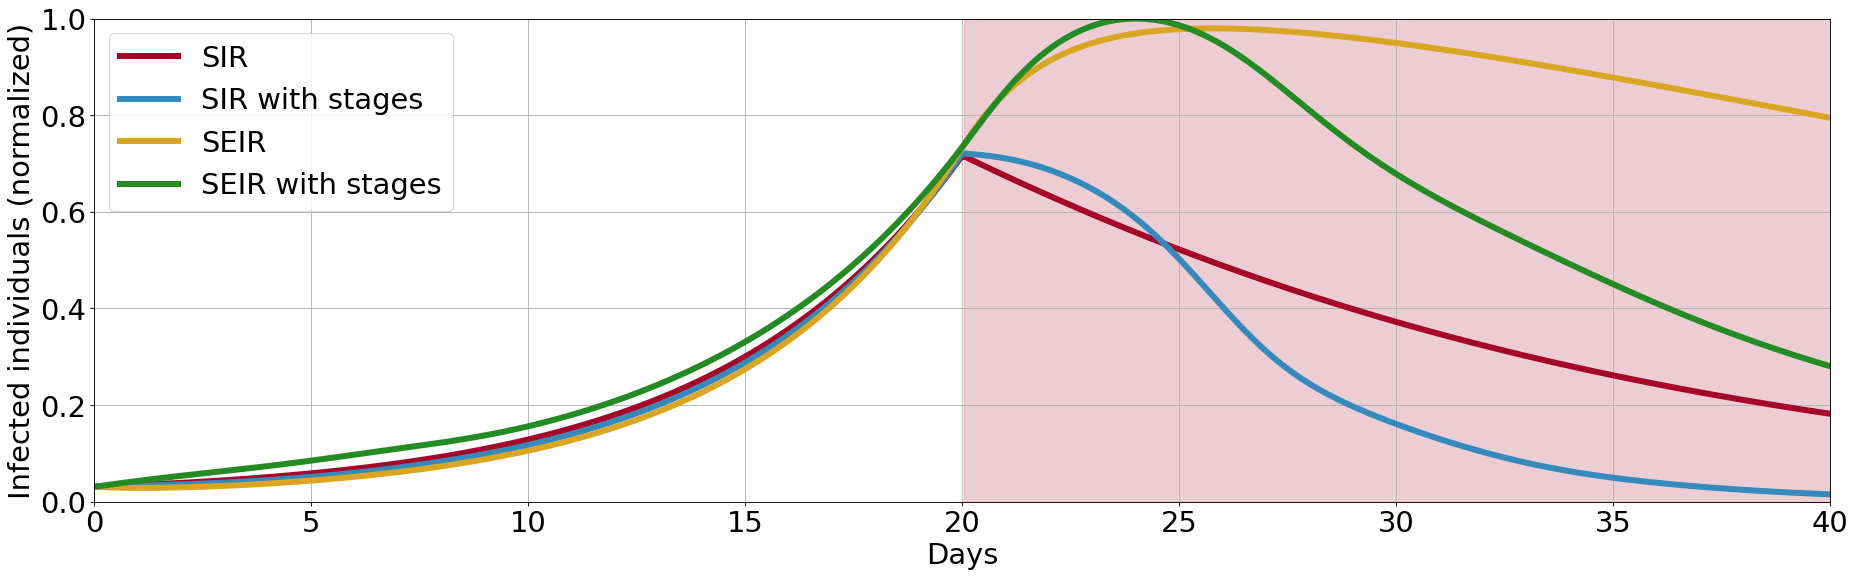

In [9]:
asISEkIkR = ISEkIkR.sum(axis=1);  maxI=np.max(asISEkIkR)

asIsSIR = IsSIR.sum(axis=1)/maxI; asIsSEIR = IsSEIR.sum(axis=1)/maxI; 
asISIkR = ISIkR.sum(axis=1)/maxI; asISEkIkR = ISEkIkR.sum(axis=1)/maxI

fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26}); t = dataSEIR['t']; lwd=5.4

plt.plot(t, asIsSIR, '-', lw=lwd, color='#A60628', label='SIR')
plt.plot(t, asISIkR, '-', lw=lwd, color='#348ABD', label='SIR with stages')

plt.plot(t, asIsSEIR, '-', lw=lwd, color='goldenrod', label='SEIR')
plt.plot(t, asISEkIkR, '-', lw=lwd, color='forestgreen', label='SEIR with stages')
plt.fill_between(t[300:], 0, 1, color="#A60628", alpha=0.2)

plt.autoscale(enable=True, axis='x', tight=True); plt.legend()
plt.ylabel('Infected individuals (normalized)'); plt.xlabel('Days'); plt.grid()
plt.ylim(0, 1); plt.xlim(0, Tf);
plt.autoscale(enable=True, axis='x', tight=True);

We show that SIR and SIkR are discontinuous when lockdown is imposed, while SEIR and SEkIkR are continuous. 

The first derivative of SEIR is discontinuous.

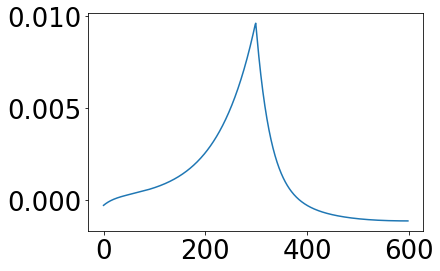

In [10]:
plt.plot(asIsSEIR[1::] - asIsSEIR[0:asIsSEIR.size -1])